<a href="https://colab.research.google.com/github/Alex45121/AI_Style_sheet/blob/main/Style_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q numpy pandas matplotlib torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.init as init

In [57]:
csv_path = "/content/drive/MyDrive/AI_project/data/style_rating_template.csv"
images_path = "/content/drive/MyDrive/AI_project/data/Images"
test_image_path = "/content/drive/MyDrive/AI_project/data/Test/Image_city.jpg"
csv_path_2 = "/content/drive/MyDrive/AI_project/data/style_rating_template_Large_cleaned_2.csv"
csv_path_short = "/content/drive/MyDrive/AI_project/data/style_rating_small.csv"
images_path_short = "/content/drive/MyDrive/AI_project/data/Images_2"


In [9]:
class StyleDataset(Dataset):

  def __init__(self, csv_file, img_dir, transform = None):
    self.data = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])

    image = Image.open(img_name).convert("RGB")

    if self.transform:
      image = self.transform(image)

    ratings = self.data.iloc[idx, 1:5].values.astype(np.float32)
    ratings = torch.tensor(ratings)

    # Load tags
    tags = self.data.iloc[idx, 5]  # this will be a string for now



    return image, ratings, tags


In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.ToTensor()           # Convert PIL Image to tensor
])

In [10]:
dataset = StyleDataset(csv_file=csv_path_2, img_dir = images_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

short_dataset = StyleDataset(csv_file=csv_path_short, img_dir = images_path_short, transform=transform)
short_dataloader = DataLoader(short_dataset, batch_size=4, shuffle=True)

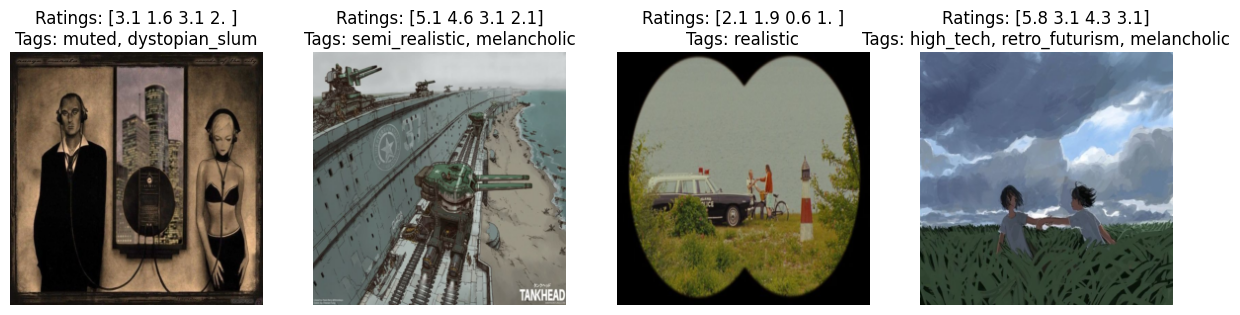

In [12]:
def show_batch(images, ratings, tags):
    fig, axes = plt.subplots(1, len(images), figsize=(15,5))
    for idx, img in enumerate(images):
        img = img.permute(1, 2, 0)  # rearrange tensor to HWC
        axes[idx].imshow(img)
        axes[idx].set_title(f"Ratings: {ratings[idx].numpy()}\nTags: {tags[idx]}")
        axes[idx].axis('off')
    plt.show()

# Get one batch
images, ratings, tags = next(iter(short_dataloader))
show_batch(images, ratings, tags)

In [58]:
image_t = Image.open(test_image_path)
image_t = image_t.convert('RGB')

transform_t = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to 64x64 (ensure it's large enough for the model)
    transforms.RandomHorizontalFlip(),  # Data Augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Optional normalization
])

sample_image_t= transform_t(image_t).unsqueeze(0)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class StyleNet(nn.Module):
    def __init__(self):
        super(StyleNet, self).__init__()

        # Feature extractor (CNN)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers (MLP)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 outputs: style_look, prop_style, color_grading, scene_mood

        init.xavier_uniform_(self.conv1.weight)
        init.xavier_uniform_(self.conv2.weight)
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training) # Dropout added
        x = self.fc2(x)  # Final output




        return x



In [15]:
model = StyleNet()

model.load_state_dict(torch.load("/content/drive/MyDrive/AI_project/models/model_test_1.pth"))

model.eval()  # Optional: put in evaluation mode

model_2 = StyleNet()

model_2.load_state_dict(torch.load("/content/drive/MyDrive/AI_project/models/model_2_test_2_big.pth"))

model_2.eval()



StyleNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [25]:
model_3 = StyleNet()

In [45]:
# INITIAL TRAINING FOR MODEL, MODEL_2 and MODEL_3
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


criterion = nn.MSELoss()
"""optimizer = optim.Adam(model.parameters(), lr=0.001)"""
optimizer_2 = optim.Adam(model_3.parameters(), lr=0.001, weight_decay= 0.01)


"""scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3) # reduce lr when validation loss plateaus for 3 epochs"""
scheduler_2 = ReduceLROnPlateau(optimizer_2, 'min', patience=3) # reduce lr when validation loss plateaus for 3 epochs

In [46]:
# INITIAL TRAINING FOR MODEL, MODEL_2 and MODEL_3
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(dataset, test_size=0.30, random_state=42)  # 20% for validation

In [43]:
# INITIAL TRAINING FOR MODEL, MODEL_2 and MODEL_3

train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)  # Your existing training data loader

val_dataloader = DataLoader(val_data, batch_size=4, shuffle=False)  # New validation data loader

In [47]:
# INITIAL TRAINING FOR MODEL and MODEL_2
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0

    for images, ratings, tags in train_dataloader:
        # Move to GPU if available
        images = images
        ratings = ratings

        # Zero the parameter gradients
        optimizer_2.zero_grad()

        # Forward pass
        outputs = model_3(images)

        # Compute Loss


        loss = criterion(outputs, ratings)

        # Backward pass + optimize
        loss.backward()
        optimizer_2.step()

        running_loss += loss.item()

    model_3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_ratings, val_tags in val_dataloader:  # Your validation data

          outputs = model_3(val_images)

          val_loss += criterion(outputs, val_ratings).item()
        val_loss /= len(val_dataloader)

    scheduler_2.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/10], Loss: 3.8398, Val Loss: 6.0271
Epoch [2/10], Loss: 1.5597, Val Loss: 6.5763
Epoch [3/10], Loss: 1.0398, Val Loss: 4.8769
Epoch [4/10], Loss: 0.4858, Val Loss: 4.8356
Epoch [5/10], Loss: 0.4851, Val Loss: 5.4499
Epoch [6/10], Loss: 0.3736, Val Loss: 4.7013
Epoch [7/10], Loss: 0.3866, Val Loss: 4.8463
Epoch [8/10], Loss: 0.3355, Val Loss: 5.3246
Epoch [9/10], Loss: 0.4960, Val Loss: 5.7821
Epoch [10/10], Loss: 0.7779, Val Loss: 5.1962


In [24]:
# New Information and finetuning for the first mdoel

from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_data_s, val_data_s = train_test_split(short_dataset, test_size=0.2, random_state = 66)

train_dataloader_s = DataLoader(train_data_s, batch_size=4, shuffle=True)
val_dataloader_s = DataLoader(val_data_s, batch_size=4, shuffle=False)

optimizer_s = torch.optim.Adam(model.parameters(), lr=0.001)
criterion_s = nn.MSELoss()
scheduler_s = ReduceLROnPlateau(optimizer_s, 'min', patience=3)
num_epochs = 9


for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for images, ratings, tags in train_dataloader_s:
      optimizer_s.zero_grad()
      outputs = model(images)
      loss = criterion_s(outputs, ratings)
      loss.backward()
      optimizer_s.step()
      running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_ratings, val_tags in val_dataloader_s:  # Your validation data

          outputs = model(val_images)

          val_loss += criterion_s(outputs, val_ratings).item()
        val_loss /= len(val_dataloader_s)

    scheduler_s.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}, Val Loss: {val_loss:.4f}")



Epoch [1/9], Loss: 4.2333, Val Loss: 5.6447
Epoch [2/9], Loss: 3.9181, Val Loss: 7.0293
Epoch [3/9], Loss: 3.0287, Val Loss: 6.4650
Epoch [4/9], Loss: 2.7632, Val Loss: 5.9867
Epoch [5/9], Loss: 1.9109, Val Loss: 6.1214
Epoch [6/9], Loss: 1.7813, Val Loss: 6.9028
Epoch [7/9], Loss: 1.7335, Val Loss: 6.6782
Epoch [8/9], Loss: 1.9051, Val Loss: 6.5117
Epoch [9/9], Loss: 1.6400, Val Loss: 6.8061


Predictions for **model_2**

________

In [60]:

# Predict with image outsdie of testing
model_2.eval()  # set model to evaluation mode
with torch.no_grad():
    prediction = model_2(sample_image_t)
    prediction = torch.clamp(prediction,0,10)


print("Predicted Ratings:", prediction)

Predicted Ratings: tensor([[10.0000, 10.0000,  8.8373,  9.5759]])


In [27]:
# Pick an image
sample_image, _, _ = dataset[70]  # 0 = first image
sample_image = sample_image.unsqueeze(0)

# Predict
model_2.eval()  # set model to evaluation mode
with torch.no_grad():
    prediction = model_2(sample_image)
    prediction = torch.clamp(prediction, 0.0, 10.0)

print("Predicted Ratings:", prediction)

Predicted Ratings: tensor([[6.3549, 5.8997, 5.1705, 2.4206]])


Predictions for **model**

________

In [26]:
# Pick an image
sample_image, _, _ = dataset[70]  # 0 = first image
sample_image = sample_image.unsqueeze(0)

# Predict
model.eval()  # set model to evaluation mode
with torch.no_grad():
    prediction = model(sample_image)
    prediction = torch.clamp(prediction, 0.0, 10.0)

print("Predicted Ratings:", prediction)

Predicted Ratings: tensor([[4.6895, 4.7230, 5.3655, 3.6539]])


In [61]:
# Predict with image outsdie of testing
model.eval()  # set model to evaluation mode
with torch.no_grad():
    prediction = model(sample_image_t)
    prediction = torch.clamp(prediction,0,10)


print("Predicted Ratings:", prediction)

Predicted Ratings: tensor([[10.0000,  7.9551,  7.1203, 10.0000]])


Predictions for **model_3**

_________

In [51]:
# Pick an image
sample_image, _, _ = dataset[85]  # 0 = first image
sample_image = sample_image.unsqueeze(0)

# Predict
model_3.eval()  # set model to evaluation mode
with torch.no_grad():
    prediction = model_3(sample_image)
    prediction = torch.clamp(prediction, 0.0, 10.0)

print("Predicted Ratings:", prediction)

Predicted Ratings: tensor([[3.8403, 3.1660, 2.9758, 1.9389]])


In [62]:
# Predict with image outsdie of testing
model_3.eval()  # set model to evaluation mode
with torch.no_grad():
    prediction = model_3(sample_image_t)


print("Predicted Ratings:", prediction)

Predicted Ratings: tensor([[10.7081, 30.4189, 10.9187, 13.1143]])


In [63]:
torch.save(model_3.state_dict(), "/content/drive/MyDrive/AI_project/models/model_3_test_3_big.pth")

In [64]:
!ls /content/drive/MyDrive/AI_project/models/

model_2_test_2_big.pth	model_3_test_3_big.pth	model_test_1.pth
